In [1]:
import string

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pandas as pd

from tqdm import tqdm
tqdm.pandas()

import joblib

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Colab/ethnicolor/data/all_mentioned_names_lnfn.csv")

In [3]:
df['full_name'] = df['full_name'].str.strip()
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [4]:
df.head()

,full_name,channel
0,Hochul Kathy,cnn
1,Clavin Don,cnn
2,Bellone Steve,cnn
3,Levine Ian,cnn
4,Zanona Melanie,cnn


In [5]:
df.describe()

,full_name,channel
count,429449,429449
unique,277107,11
top,Doe Jane,wapo
freq,16,81268


In [6]:
vectorizer = joblib.load('/content/drive/MyDrive/Colab/ethnicolor/models_v2/lstm/pt_vec_fullname.joblib')


In [7]:
max_name = 47
all_categories =  ['asian', 'hispanic', 'nh_black', 'nh_white', 'other']
n_categories = len(all_categories)

vocab = list(vectorizer.get_feature_names_out())
all_letters = ''.join(vocab)
n_letters = len(vocab)
oob = n_letters + 1
vocab_size = oob + 1

In [8]:
# A custom Dataset class must implement three functions: __init__, __len__, and __getitem__

class EthniColorDataset(Dataset):
  def __init__(self, data_df, transform=None):
    self.df = data_df
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    name = self.df.iloc[idx, df.columns.get_loc('full_name')]
    if self.transform:
      name_ids = self.transform(name)
    return name, name_ids

In [9]:
def letterToIndex(letter):
    return all_letters.find(letter)

def lineToTensor(line):
    # if name is more than max_name
    try:
      if len(line) > max_name:
        line = line[:max_name]
      tensor = torch.ones(max_name) * oob
      for li, letter in enumerate(line):
          tensor[li] = letterToIndex(letter)
    except:
      print(line)
      raise
    return tensor

In [10]:
dataset = EthniColorDataset(df, lineToTensor)

In [11]:
for i in range(3):
  name, ids  = dataset[i]
  print(i, name, ids)

0 Hochul Kathy tensor([10., 43., 31., 36., 49., 40.,  0., 13., 29., 48., 36., 53., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56.])
1 Clavin Don tensor([ 5., 40., 29., 50., 37., 42.,  0.,  6., 43., 42., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56.])
2 Bellone Steve tensor([ 4., 33., 40., 40., 43., 42., 33.,  0., 21., 48., 33., 50., 33., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56.])


In [12]:
import os

batch_size=1024

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=os.cpu_count())

In [13]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, len(sample_batched[0]), sample_batched[1].size())
    if i_batch == 2:
        break

0 1024 torch.Size([1024, 47])
1 1024 torch.Size([1024, 47])
2 1024 torch.Size([1024, 47])


In [14]:
# Set the random seed for reproducible results
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # The nn.Embedding layer returns a new tensor with dimension (sequence_length, 1, hidden_size)
        self.embedding = nn.Embedding(input_size, hidden_size)
        # LSTM layer expects a tensor of dimension (batch_size, sequence_length, hidden_size).
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        embedded = self.embedding(input.type(torch.IntTensor).to(input.device))
        # embedded = embedded.view(embedded.shape[0],-1,embedded.shape[3])
        h0 = torch.zeros(self.num_layers, embedded.size(0), self.hidden_size).to(input.device)
        c0 = torch.zeros(self.num_layers, embedded.size(0), self.hidden_size).to(input.device)
        out, _ = self.lstm(embedded, (h0, c0))
        out = out[:, -1, :]  # get the output of the last time step
        out = self.fc(out)
        out = self.softmax(out)
        return out


n_hidden = 256
seq_len = max_name

model = LSTM(vocab_size, n_hidden, n_categories, num_layers=2)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab/ethnicolor/models_v2/lstm/lstm_fullname.pt', map_location=device))
model.to(device)

LSTM(
  (embedding): Embedding(57, 256)
  (lstm): LSTM(256, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [15]:
# Set the model to evaluation mode
model.eval()

# Disable gradient calculations
with torch.no_grad():
    # List to hold the predictions
    predictions = []
    names = []

    # Loop over the batches
    for batch in tqdm(dataloader):
        # Move the batch to the device the model is on
        nms = list(batch[0])
        tns = batch[1].to(device)
        # Compute the predictions
        outputs = model(tns)
        outputs = torch.argmax(outputs, dim=1)
        # Move the predictions to the CPU and convert to numpy arrays
        outputs = outputs.cpu().numpy()
        # Append the predictions to the list
        predictions.extend(list(outputs))
        names.extend(nms)

100%|██████████| 419/419 [00:12<00:00, 33.81it/s]


In [16]:
results_df = pd.DataFrame({'names': names, 'predictions':predictions})

In [17]:
results_df.head()

,names,predictions
0,Lumpkin's Mary,2
1,HECKMAN JULIE,0
2,Turner Nicholas,3
3,Goble John,3
4,Pierce Maggie,3


In [18]:
results_df['preds'] = results_df['predictions'].apply(lambda x: all_categories[x])

In [19]:
results_df.head()

,names,predictions,preds
0,Lumpkin's Mary,2,nh_black
1,HECKMAN JULIE,0,asian
2,Turner Nicholas,3,nh_white
3,Goble John,3,nh_white
4,Pierce Maggie,3,nh_white


In [20]:
results_df.shape

(429056, 3)

In [21]:
results_df['preds'].value_counts()

nh_white    315262
nh_black     40963
asian        36785
hispanic     34529
other         1517
Name: preds, dtype: int64

In [22]:
res_dict = results_df['preds'].value_counts().to_dict()

<Axes: >

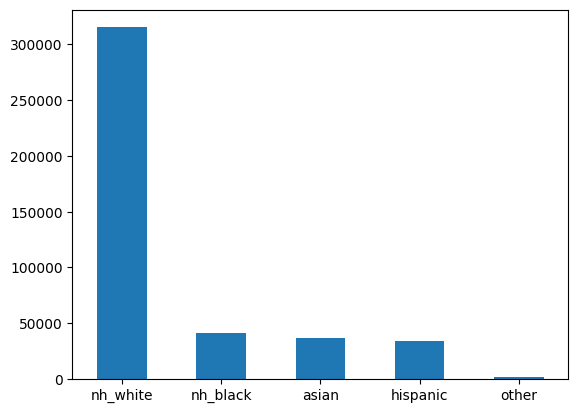

In [23]:
results_df['preds'].value_counts().plot.bar(x='lab', y='val', rot=0)

In [24]:
results_df.shape[0]

429056

In [25]:
res_dict

{'nh_white': 315262,
 'nh_black': 40963,
 'asian': 36785,
 'hispanic': 34529,
 'other': 1517}

In [26]:
for x in res_dict:
  print(f"{x} - {round(res_dict[x]/results_df.shape[0], 3)}%")

nh_white - 0.735%
nh_black - 0.095%
asian - 0.086%
hispanic - 0.08%
other - 0.004%


In [29]:
# prompt: merge df and results_df based on full_name and names

df1 = pd.merge(df, results_df.drop_duplicates(subset=['names'], keep='first'), left_on='full_name', right_on='names')
print(df1.head())

      full_name channel         names  predictions     preds
0  Hochul Kathy     cnn  Hochul Kathy            3  nh_white
1  Hochul Kathy     abc  Hochul Kathy            3  nh_white
2  Hochul Kathy     cbs  Hochul Kathy            3  nh_white
3  Hochul Kathy     nbc  Hochul Kathy            3  nh_white
4  Hochul Kathy     npr  Hochul Kathy            3  nh_white


In [31]:
df1 = df1[['full_name', 'channel', 'preds', 'predictions']]

In [32]:
df1.groupby(['channel', 'preds']).size()

channel   preds   
abc       asian         983
          hispanic     1434
          nh_black     1266
          nh_white    10381
          other          51
cbs       asian        3036
          hispanic     3003
          nh_black     3757
          nh_white    32256
          other         144
cnn       asian        4873
          hispanic     3876
          nh_black     5233
          nh_white    41670
          other         255
lat       asian        5796
          hispanic     8771
          nh_black     6796
          nh_white    47992
          other         168
nbc       asian        2842
          hispanic     3220
          nh_black     3112
          nh_white    25934
          other         131
npr       asian        5391
          hispanic     3098
          nh_black     3592
          nh_white    30003
          other         213
nyt       asian        2172
          hispanic     1667
          nh_black     2123
          nh_white    18960
          other         107
p

<Axes: xlabel='channel'>

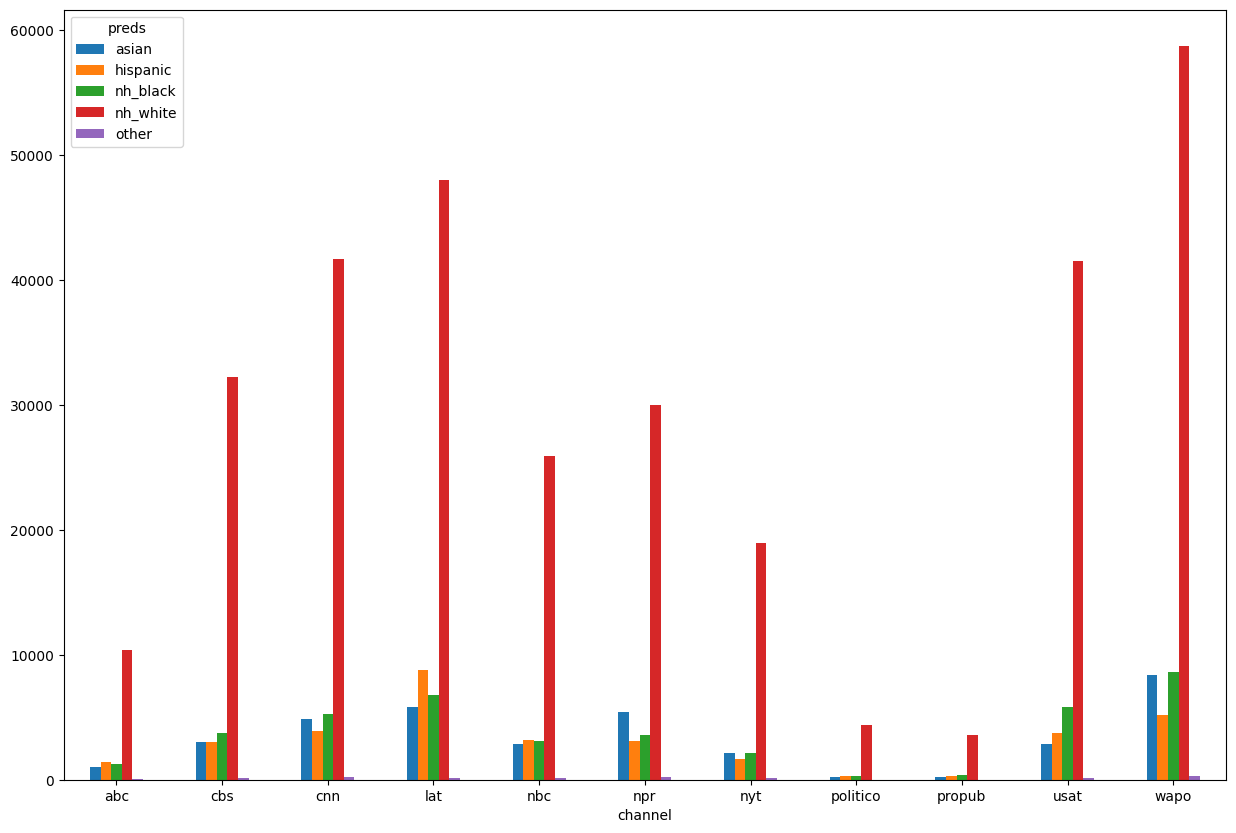

In [33]:
df1.groupby(['channel', 'preds']).size().unstack(fill_value=0).plot(kind='bar', figsize=(15, 10), rot=0)


In [34]:
def plot_by(channel):
  df1[df1['channel'] == channel].groupby(['channel', 'preds']).size().unstack(fill_value=0).plot(kind='bar', figsize=(10, 5), rot=0)


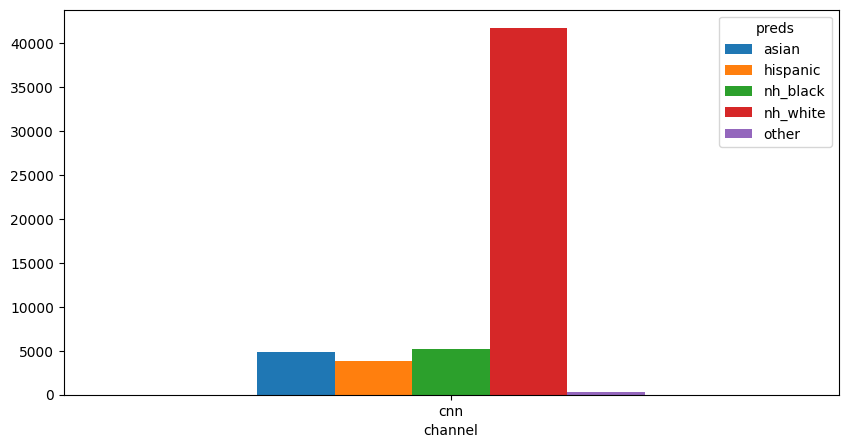

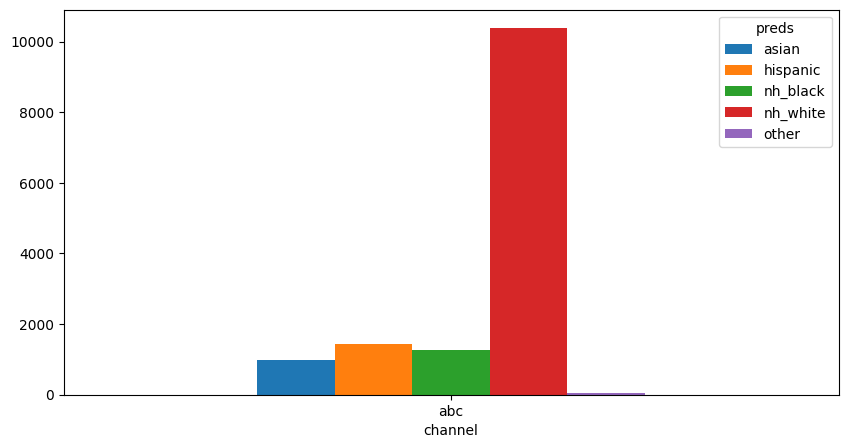

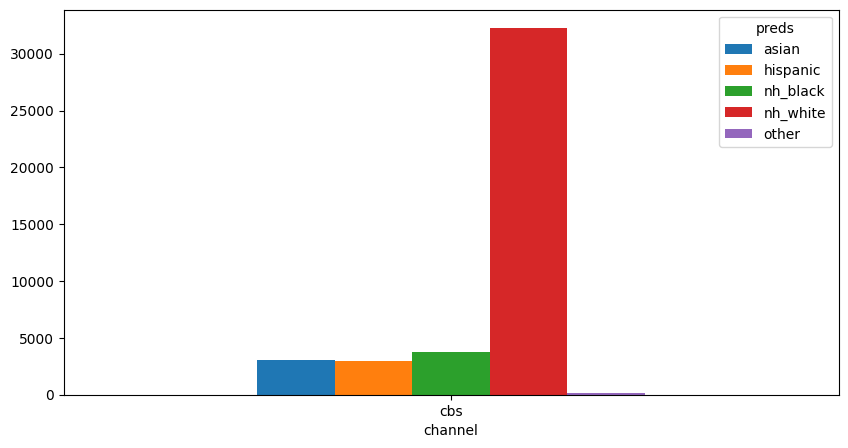

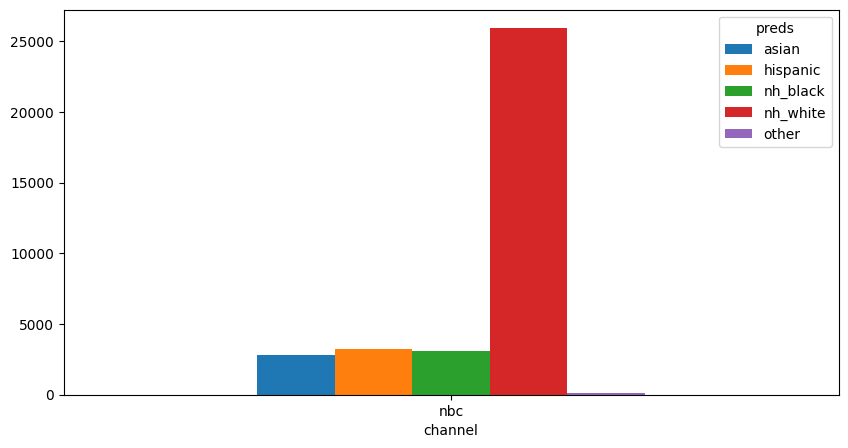

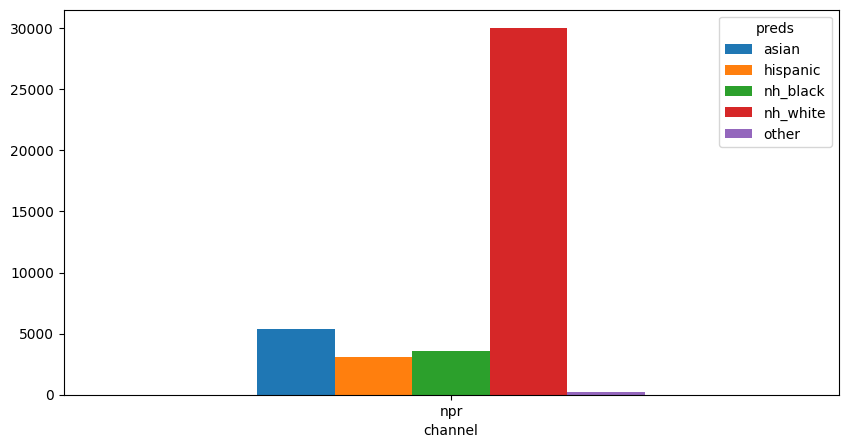

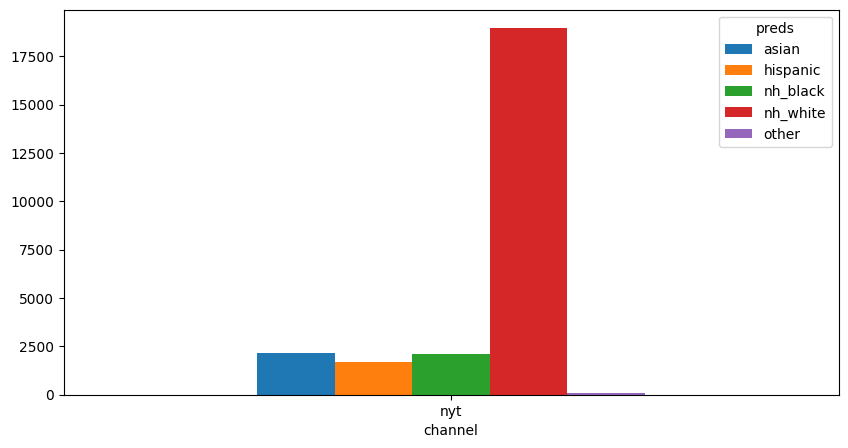

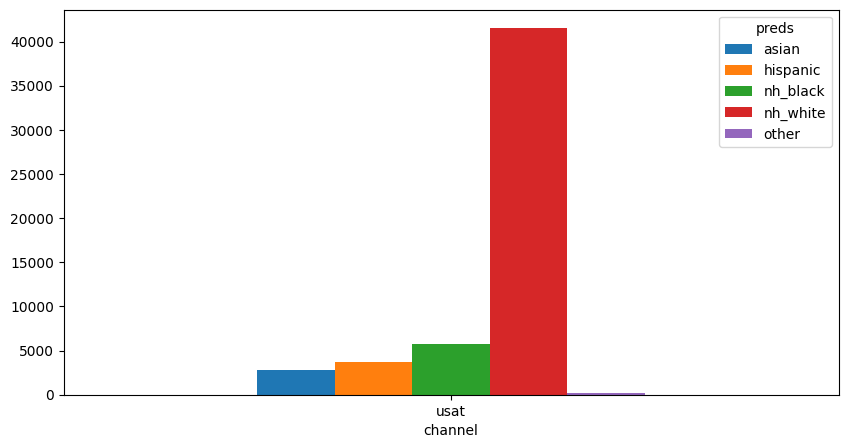

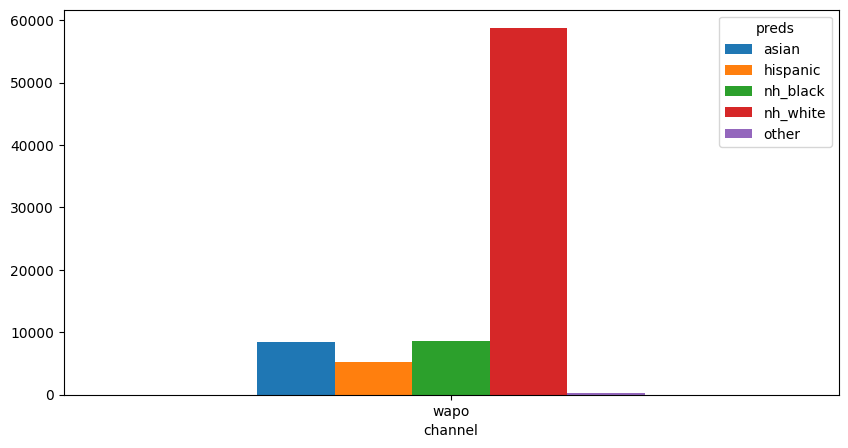

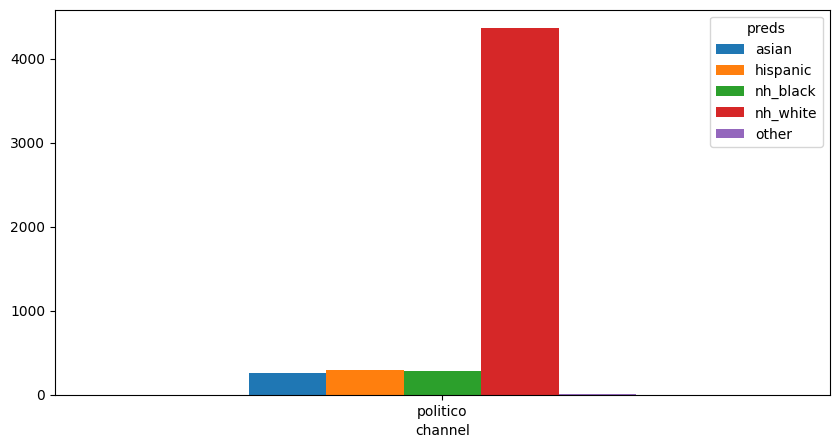

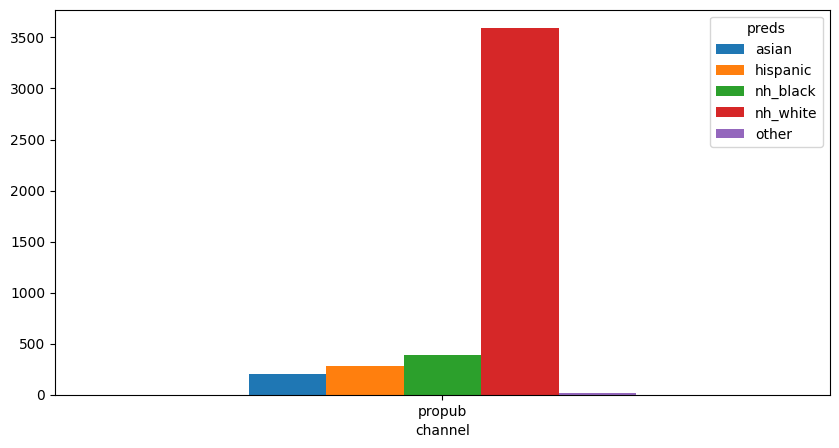

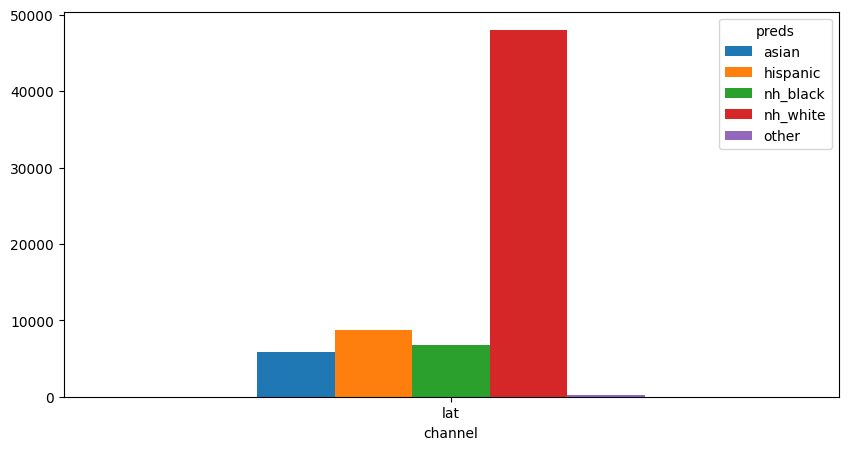

In [35]:
for channel in df1['channel'].unique():
  plot_by(channel)

In [36]:
df1.to_csv("/content/drive/MyDrive/Colab/ethnicolor/data/news_mentioned_names_results.csv", index=False)

In [37]:
ch_pr = df1.groupby(['channel', 'preds']).size().to_dict()

news = {}
totals = {}
for x in ch_pr:
  channel = x[0]
  preds = x[1]
  if channel not in news:
    news[channel] = {}
    totals[channel] = 0
  news[channel][preds] = ch_pr[x]
  totals[channel] += ch_pr[x]

In [38]:
for channel in news:
  print(channel)
  for race in news[channel]:
    print(f"{race} - {round(news[channel][race]/totals[channel], 3)}%")
  print()

abc
asian - 0.07%
hispanic - 0.102%
nh_black - 0.09%
nh_white - 0.735%
other - 0.004%

cbs
asian - 0.072%
hispanic - 0.071%
nh_black - 0.089%
nh_white - 0.764%
other - 0.003%

cnn
asian - 0.087%
hispanic - 0.069%
nh_black - 0.094%
nh_white - 0.745%
other - 0.005%

lat
asian - 0.083%
hispanic - 0.126%
nh_black - 0.098%
nh_white - 0.69%
other - 0.002%

nbc
asian - 0.081%
hispanic - 0.091%
nh_black - 0.088%
nh_white - 0.736%
other - 0.004%

npr
asian - 0.127%
hispanic - 0.073%
nh_black - 0.085%
nh_white - 0.709%
other - 0.005%

nyt
asian - 0.087%
hispanic - 0.067%
nh_black - 0.085%
nh_white - 0.758%
other - 0.004%

politico
asian - 0.049%
hispanic - 0.057%
nh_black - 0.055%
nh_white - 0.837%
other - 0.002%

propub
asian - 0.045%
hispanic - 0.064%
nh_black - 0.086%
nh_white - 0.802%
other - 0.003%

usat
asian - 0.053%
hispanic - 0.069%
nh_black - 0.107%
nh_white - 0.769%
other - 0.003%

wapo
asian - 0.103%
hispanic - 0.064%
nh_black - 0.106%
nh_white - 0.723%
other - 0.003%

